# README

This notebook is a part of the implementation of ["Adversarial Network Traffic: Towards Evaluating the Robustness of Deep Learning-Based Network Traffic Classification"](https://arxiv.org/abs/2003.01261), including the implementation of flow time series classifiers FTSC-PS, and FTSC-IAT, and the implementation of AdvBurst, and RandBurst attacks.

following files and directories are required to replicate the results of the paper:
* FTSC/
  * Classifiers/
    * FTSC-PS_classifier
    * FTSC-IAT_classifier
  * Adv‌Burst/
    * AdvBurst_FTSC-IAT/(adversarial burst)
    * AdvBurst_FTSC-PS/(adversarial burst)
    * MAKED_BURST
  * Dataset/
    * Dataset/FTSC_Dataset.pickle


The prerequisites for this notebook are as follows:
1. python 3.6
2. numpy 1.18.2
3. tensorflow-gpu 1.15
4. keras 2.2.5
5. pandas 1.0.3
6. pickle 4.0
7. matplotlib 3.2.1 

All codes have been run on [google colab](https://colab.research.google.com/).


# Configuration
This notebook must run two times in **separate sessions runtime** with different configs from top cell to bottom cell to replicate the results of the paper.

1.   Adv‌Burst and RandBurst attacks on FTSC-PS
  * FTSC = 'FTSC-PS' 
  * Train_classifier = 0 
  * Load_advburst = 1 
2.   AdvBurst and RandBurst attacks on FTSC-IAT
  * FTSC = 'FTSC-IAT' 
  * Train_classifier = 0 
  * Load_advburst = 1 

To train a new classifier, first, the input space must be determined by FTSC parameter, and then Train_classifier parameter must be set 1 (if you train a new classifier, then new adversarial burst is generated). The trained classifier is saved in FTSC/Classifiers directory. The architecture and hyperparameters of the classifier are determined by models.json file.

For example, to train a new classifier FTSC-PS and to run AdvBurst attack on it, the config is as follows: 
  * FTSC = 'FTSC-PS' 
  * Train_classifier = 1 
  * Load_advburst = 0

To generate new adversarial burst on existing classifiers, the parameter Load_advburst must be set 0. Generated adversarial burst is saved in FTSC/AdvBurst/MAKED_Burst directory.

For example, to run AdvBurst attack on FTSC-IAT, the config is as follows:
  * FTSC = 'FTSC-IAT' 
  * Train_classifier = 0 
  * Load_dvburst = 0 




In [0]:
#Config
FTSC = 'FTSC-IAT' # FTSC-PS or FTSC-IAT
Train_classifier = 0 # 0 -> Load existing classifiers, and 1 -> Train a new classifier with name Traind_Model in FTSC/Classifiers directory 
Load_advburst = 1 # 0 -> Run AdvBurst attack and will make new adversarial burst, and 1 -> Load existing adversarial burst that has been used in the paper

%cd 'drive/My Drive/ANT_Paper' # Location of the directory that contains FTSC files and directories

# Prerequisites

In [0]:
!pip install tensorflow-gpu==1.15.0
import tensorflow as tf
print(tf.__version__)
# Uninstall tensorflow first
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

/content/drive/My Drive/ANT_Paper


1.15.0


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7357860956081760930, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 12431445034892817415
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 3586854628185361581
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15956161332
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 18444245854350701076
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

# Utilization

In [0]:
import os
MAX_NUM_PKT_IN_FLOW_TIME_SERIES = 100
FLOW_TIME_SERIES_LEN = 1000
OVER_SAMPLING = 1

Payload_LENGTH = 1500
IP_LENGTH = 40
TL_LENGTH = 60
BATCH_SIZE = 64

ALPHA = 0

if FTSC == "FTSC-IAT":
    INPUT_ITEMS = ['Dir+IPT']
if FTSC == "FTSC-PS":
    INPUT_ITEMS = ['Dir+PktSize']
if Train_classifier == 0:
    if FTSC == "FTSC-IAT":
        TRAINED_MODEL_PATH = "FTSC/Classifiers/FTSC-IAT_Classifier"
    if FTSC == "FTSC-PS":
        TRAINED_MODEL_PATH = "FTSC/Classifiers/FTSC-PS_Classifier"
elif Train_classifier == 1:
    TRAINED_MODEL_PATH = "FTSC/Classifiers/Trained_Model" 


def flow_to_time_serie(flow, max_pkt=None):
    ts = np.zeros((FLOW_TIME_SERIES_LEN))
    for i in range(min(len(flow), max_pkt)):
        ts[i] = flow[i]
    return ts


class Normalization:

    def standardScaler(self, train_data, validation_data, test_data, clip_min=None, clip_max=None):
        if clip_min != None and clip_max != None:
            train_data = [np.clip(i, clip_min, clip_max) for i in train_data]
            validation_data = [np.clip(i, clip_min, clip_max) for i in validation_data]
            test_data = [np.clip(i, clip_min, clip_max) for i in test_data]
        mean = np.mean(np.array([j for i in train_data for j in i]))
        std = np.std(np.array([j for i in train_data for j in i]))
        normalized_train_data = (train_data - mean) / std
        normalized_validation_data = (validation_data - mean) / std
        normalized_test_data = (test_data - mean) / std
        return normalized_train_data, normalized_validation_data, normalized_test_data, mean, std

    def devideByMaxScaler(self, train_data, validation_data, test_data, clip_min=None, clip_max=None):
        if clip_min != None and clip_max != None:
            train_data = [np.clip(i, clip_min, clip_max) for i in train_data]
            validation_data = [np.clip(i, clip_min, clip_max) for i in validation_data]
            test_data = [np.clip(i, clip_min, clip_max) for i in test_data]
        train_max = np.max(np.array([np.abs(j) for i in train_data for j in i]))
        normalized_train_data = train_data / train_max
        normalized_validation_data = validation_data / train_max
        normalized_test_data = test_data / train_max
        return normalized_train_data, normalized_validation_data, normalized_test_data, train_max

    def change_min_to_zero(self, train_data, validation_data, test_data, clip_min=None, clip_max=None):
        if clip_min != None and clip_max != None:
            train_data = [np.clip(i, clip_min, clip_max) for i in train_data]
            validation_data = [np.clip(i, clip_min, clip_max) for i in validation_data]
            test_data = [np.clip(i, clip_min, clip_max) for i in test_data]
        train_min = np.min(np.array([j for i in train_data for j in i]))
        validation_min = np.min(np.array([j for i in validation_data for j in i]))
        test_min = np.min(np.array([j for i in test_data for j in i]))
        normalized_train_data = train_data + (train_min < 0) * np.abs(train_min)
        normalized_validation_data = validation_data + (validation_min < 0) * np.abs(validation_min)
        normalized_test_data = test_data + (test_min < 0) * np.abs(test_min)
        return normalized_train_data, normalized_validation_data, normalized_test_data, train_min, validation_min, test_min

    def log_normalization(self, train_data, validation_data, test_data, clip_min=None, clip_max=None):
        if clip_min != None and clip_max != None:
            train_data = [np.clip(i, clip_min, clip_max) for i in train_data]
            validation_data = [np.clip(i, clip_min, clip_max) for i in validation_data]
            test_data = [np.clip(i, clip_min, clip_max) for i in test_data]
        train_max = np.max(np.array([np.abs(j) for i in train_data for j in i]))
        normalized_train_data = [(2 * (np.log(i + 1) / np.log(train_max))) - 1 for i in train_data]
        normalized_validation_data = [(2 * (np.log(i + 1) / np.log(train_max))) - 1 for i in validation_data]
        normalized_test_data = [(2 * (np.log(i + 1) / np.log(train_max))) - 1 for i in test_data]
        normalized_train_data = [np.nan_to_num(i) for i in normalized_train_data]
        normalized_validation_data = [np.nan_to_num(i) for i in normalized_validation_data]
        normalized_test_data = [np.nan_to_num(i) for i in normalized_test_data]
        normalized_train_data = [np.clip(i, -1, 1) for i in normalized_train_data]
        normalized_validation_data = [np.clip(i, -1, 1) for i in normalized_validation_data]
        normalized_test_data = [np.clip(i, -1, 1) for i in normalized_test_data]
        return normalized_train_data, normalized_validation_data, normalized_test_data, train_max

    def PktSizeNormalization(self, train_PktSize, validation_PktSize, test_PktSize):
        normalized_train_PktSize, normalized_validation_PktSize, normalized_test_PktSize, mean, std = self.standardScaler(
            train_PktSize,
            validation_PktSize,
            test_PktSize,
            clip_min=0,
            clip_max=1500)
        self.PS_mean = mean
        self.PS_std = std
        normalized_train_PktSize, normalized_validation_PktSize, normalized_test_PktSize, train_min, val_min, test_min = self.change_min_to_zero(
            normalized_train_PktSize, normalized_validation_PktSize, normalized_test_PktSize)
        self.PS_train_min = train_min
        self.PS_val_min = val_min
        self.PS_test_min = test_min
        normalized_train_PktSize, normalized_validation_PktSize, normalized_test_PktSize, train_max = self.devideByMaxScaler(
            normalized_train_PktSize, normalized_validation_PktSize, normalized_test_PktSize)
        self.PS_train_max = train_max
        return normalized_train_PktSize, normalized_validation_PktSize, normalized_test_PktSize

    def IPTNormalization(self, train_InterPktTime, validation_InterPktTime, test_InterPktTime):
        normalized_train_InterPktTime, normalized_validation_InterPktTime, normalized_test_InterPktTime, train_max_log = self.log_normalization(
            train_InterPktTime, validation_InterPktTime, test_InterPktTime)
        self.IPT_train_max_log = train_max_log
        normalized_train_InterPktTime, normalized_validation_InterPktTime, normalized_test_InterPktTime, train_max = self.devideByMaxScaler(
            normalized_train_InterPktTime, normalized_validation_InterPktTime, normalized_test_InterPktTime)
        self.IPT_train_max = train_max
        normalized_train_InterPktTime, normalized_validation_InterPktTime, normalized_test_InterPktTime, train_min, val_min, test_min = self.change_min_to_zero(
            normalized_train_InterPktTime, normalized_validation_InterPktTime, normalized_test_InterPktTime)
        self.IPT_train_min = train_min
        self.IPT_val_min = val_min
        self.IPT_test_min = test_min
        return normalized_train_InterPktTime, normalized_validation_InterPktTime, normalized_test_InterPktTime

    def revers_PktSizeNormalization(self, normalized_data, set_name=None):
        if set_name == "train":
            min_val = self.PS_train_min
        elif set_name == "test":
            min_val = self.PS_test_min
        elif set_name == "validation":
            min_val = self.PS_val_min
        return np.array(
            [(((f * self.PS_train_max) - np.abs(min_val)) * self.PS_std) + self.PS_mean for f
             in normalized_data])

    def direct_PktSizeNormalization(self, orginal_data, set_name=None):
        if set_name == "train":
            min_val = self.PS_train_min
        elif set_name == "test":
            min_val = self.PS_test_min
        elif set_name == "validation":
            min_val = self.PS_val_min
        return np.array(
            [(((np.clip(0, 1500, f) - self.PS_mean) / self.PS_std) + np.abs(min_val)) / self.PS_train_max for f in
             orginal_data])

    def revers_IPTNormalization(self, normalized_data, set_name=None):
        if set_name == "train":
            min_val = self.IPT_train_min
        elif set_name == "test":
            min_val = self.IPT_test_min
        elif set_name == "validation":
            min_val = self.IPT_val_min
        return [(np.exp(((((f - np.abs(min_val)) * self.IPT_train_max) + 1) / 2) * np.log(self.IPT_train_max_log))) - 1
                for f in normalized_data]

    def direct_IPTNormalization(self, orginal_data, set_name=None):
        if set_name == "train":
            min_val = self.IPT_train_min
        elif set_name == "test":
            min_val = self.IPT_test_min
        elif set_name == "validation":
            min_val = self.IPT_val_min
        return [((2 * (np.log(np.clip(0, self.IPT_train_max_log, f) + 1) / np.log(
            self.IPT_train_max_log)) - 1) / self.IPT_train_max) + np.abs(min_val) for f in orginal_data]


def prepare_data(data, num_of_classes=None, min_num_pkt_in_ts=None, max_num_pkt_in_ts=None):
    train_InterPktTime = [np.array(i[1:])[:, 1] for i in data.train_data]
    train_PktSize = [np.array(i)[:, 2] for i in data.train_data]
    train_Dir = [np.array(i)[:, 0] for i in data.train_data]
    validation_InterPktTime = [np.array(i[1:])[:, 1] for i in data.validation_data]
    validation_PktSize = [np.array(i)[:, 2] for i in data.validation_data]
    validation_Dir = [np.array(i)[:, 0] for i in data.validation_data]
    test_InterPktTime = [np.array(i[1:])[:, 1] for i in data.test_data]
    test_PktSize = [np.array(i)[:, 2] for i in data.test_data]
    test_Dir = [np.array(i)[:, 0] for i in data.test_data]

    normalization = Normalization()
    if "Dir+PktSize" in INPUT_ITEMS:
        normalized_train_PktSize, normalized_validation_PktSize, normalized_test_PktSize = normalization.PktSizeNormalization(
            train_PktSize,
            validation_PktSize, test_PktSize)
    if "Dir+IPT" in INPUT_ITEMS:
        normalized_train_InterPktTime, normalized_validation_InterPktTime, normalized_test_InterPktTime = normalization.IPTNormalization(
            train_InterPktTime, validation_InterPktTime, test_InterPktTime)

    if 'Dir' in INPUT_ITEMS:
        train_data = train_Dir
        validation_data = validation_Dir
        test_data = test_Dir
    elif 'Dir+PktSize' in INPUT_ITEMS:
        train_data = [i * j for i, j in zip(train_Dir, normalized_train_PktSize)]
        validation_data = [i * j for i, j in zip(validation_Dir, normalized_validation_PktSize)]
        test_data = [i * j for i, j in zip(test_Dir, normalized_test_PktSize)]
    elif 'Dir+IPT' in INPUT_ITEMS:
        train_data = [i[1:] * j for i, j in zip(train_Dir, normalized_train_InterPktTime)]
        validation_data = [i[1:] * j for i, j in zip(validation_Dir, normalized_validation_InterPktTime)]
        test_data = [i[1:] * j for i, j in zip(test_Dir, normalized_test_InterPktTime)]
    elif 'IPT' in INPUT_ITEMS:
        train_data = normalized_train_InterPktTime
        validation_data = normalized_validation_InterPktTime
        test_data = normalized_test_InterPktTime
    elif 'PktSize' in INPUT_ITEMS:
        train_data = normalized_train_PktSize
        validation_data = normalized_validation_PktSize
        test_data = normalized_test_PktSize
    else:
        assert False, "Input items are empty!!!"

    train_data = np.array([flow_to_time_serie(flow=f, max_pkt=max_num_pkt_in_ts) for f in train_data])
    validation_data = np.array([flow_to_time_serie(flow=f, max_pkt=max_num_pkt_in_ts) for f in validation_data])
    test_data = np.array([flow_to_time_serie(flow=f, max_pkt=max_num_pkt_in_ts) for f in test_data])

    train_y = np.eye(num_of_classes[0])[data.train_labels_1]
    test_y = np.eye(num_of_classes[0])[data.test_labels_1]
    validation_y = np.eye(num_of_classes[0])[data.validation_labels_1]

    train_y = train_y[np.array([np.count_nonzero(i) for i in train_data]) > min_num_pkt_in_ts]
    validation_y = validation_y[np.array([np.count_nonzero(i) for i in validation_data]) > min_num_pkt_in_ts]
    test_y = test_y[np.array([np.count_nonzero(i) for i in test_data]) > min_num_pkt_in_ts]
    train_inf = data.train_information[np.array([np.count_nonzero(i) for i in train_data]) > min_num_pkt_in_ts]
    validation_inf = np.array(data.validation_information)[
        np.array([np.count_nonzero(i) for i in validation_data]) > min_num_pkt_in_ts]
    test_inf = data.test_information[np.array([np.count_nonzero(i) for i in test_data]) > min_num_pkt_in_ts]
    train_data = train_data[np.array([np.count_nonzero(i) for i in train_data]) > min_num_pkt_in_ts]
    validation_data = validation_data[np.array([np.count_nonzero(i) for i in validation_data]) > min_num_pkt_in_ts]
    test_data = test_data[np.array([np.count_nonzero(i) for i in test_data]) > min_num_pkt_in_ts]


    if OVER_SAMPLING == 1:
        count_data_of_each_class = np.zeros((len(np.unique(np.argmax(train_y, axis=1)))))
        for i in range(len(train_data)):
            count_data_of_each_class[np.argmax(train_y, axis=1)[i]] += 1
        count_data_of_each_class = np.array(list(map(int, count_data_of_each_class)))
        max_data_in_a_class = max(count_data_of_each_class)
        while min(count_data_of_each_class) != max(count_data_of_each_class):
            for i in range(len(train_data)):
                if count_data_of_each_class[np.argmax(train_y, axis=1)[i]] < max_data_in_a_class:
                    train_data = np.append(train_data, train_data[i:i + 1], axis=0)
                    train_y = np.append(train_y, train_y[i:i + 1], axis=0)
                    count_data_of_each_class[np.argmax(train_y, axis=1)[i]] += 1

    return train_data, train_y, train_inf, validation_data, validation_y, validation_inf, test_data, test_y, test_inf, normalization


def print_result_statistics(data, pred, label, inf, overhead_array=None):
    index_name = data.traget_classification_index  # default is activity
    confusion_matrix = np.zeros([len(data.name[index_name]) + 1, len(data.name[index_name]) + 1])
    true_of_each_data_category = np.zeros((len(data.name[0]), len(data.name[1]), len(data.name[2])))
    total_of_each_data_category = np.zeros((len(data.name[0]), len(data.name[1]), len(data.name[2])))
    true_size_of_flow = []
    false_size_of_flow = []
    true_count = 0
    total_count = len(pred)
    for i in range(len(pred)):
        type_label = np.where(data.name[0] == inf[i][-3])[0][0]
        app_label = np.where(data.name[1] == inf[i][-2])[0][0]
        act_label = np.where(data.name[2] == inf[i][-1])[0][0]
        dest_port = int(inf[i][3])
        total_of_each_data_category[type_label, app_label, act_label] += 1
        if np.argmax(pred[i]) == np.argmax(label[i]):
            true_size_of_flow.append(inf[i][-4])
            confusion_matrix[np.argmax(pred[i]), np.argmax(pred[i])] += 1
            true_of_each_data_category[type_label, app_label, act_label] += 1
            true_count += 1
        else:
            false_size_of_flow.append(inf[i][-4])
            confusion_matrix[np.argmax(label[i]), np.argmax(pred[i])] += 1
    acc_of_each_data_category = np.round(true_of_each_data_category / total_of_each_data_category, 4) * 100
    f_score_array = np.zeros([len(data.name[index_name])])
    for i in range(len(data.name[index_name])):
        confusion_matrix[-1, i] = np.round(confusion_matrix[i, i] / np.sum(confusion_matrix[:, i]), 4) * 100
        confusion_matrix[i, -1] = np.round(confusion_matrix[i, i] / np.sum(confusion_matrix[i, :]), 4) * 100
        f_score_array[i] = np.round((2 * (confusion_matrix[-1, i] * confusion_matrix[i, -1])) / (
                confusion_matrix[-1, i] + confusion_matrix[i, -1]), 2)
    confusion_matrix[-1, -1] = np.round(true_count / total_count, 4) * 100

    print("\n\nConfusion matrix: row, true label and column, predicted label\n")
    data_frame = pd.DataFrame(confusion_matrix, columns=np.append(data.name[index_name], ['Recall']),
                              index=np.append(data.name[index_name], ['Precision']))
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
        print(data_frame)
    print("\n\nOverall Accuracy = ", true_count / total_count)
    return np.array([f_score_array, confusion_matrix[-1, :6], confusion_matrix[:6, -1], confusion_matrix[-1, -1]])


def prepare_attack_data_PktSize(data_x, information, attack, normalization_ins, set_name=None):
    ts_mask_list = []
    data = []
    tcp_header_len = normalization_ins.direct_PktSizeNormalization([np.array([54])], set_name=set_name)[0][0]
    udp_header_len = normalization_ins.direct_PktSizeNormalization([np.array([42])], set_name=set_name)[0][0]
    for clean_ts, inf, i in zip(data_x, information, range(len(data_x))):
        ts = np.zeros([FLOW_TIME_SERIES_LEN, ])
        ts_mask = np.ones([FLOW_TIME_SERIES_LEN, ])
        sum_num_claen_pkt_in_ts = 0
        attack_ts_index = 0
        flag = 0
        for j in range(MAX_NUM_PKT_IN_FLOW_TIME_SERIES):
            sum_num_claen_pkt_in_ts += 1
            ts[attack_ts_index] = clean_ts[j]
            attack_ts_index += 1
            if clean_ts[j] > 0 and clean_ts[j + 1] < 0 and flag == 0:
                if j < 2:
                    continue
                num_of_dummy_packet = attack["AdvBurstOverHead"]
                flag = 1
                if num_of_dummy_packet > 0:
                    sum_num_claen_pkt_in_ts = sum_num_claen_pkt_in_ts - (
                            num_of_dummy_packet * (1 / attack["AdvBurstOverHead"]))
                ts_mask[attack_ts_index:min(attack_ts_index + num_of_dummy_packet, MAX_NUM_PKT_IN_FLOW_TIME_SERIES)] = 0
                if inf[4] == '17':
                    ts[attack_ts_index:min(attack_ts_index + num_of_dummy_packet,
                                           MAX_NUM_PKT_IN_FLOW_TIME_SERIES)] = tcp_header_len
                elif inf[4] == '6':
                    ts[attack_ts_index:min(attack_ts_index + num_of_dummy_packet,
                                           MAX_NUM_PKT_IN_FLOW_TIME_SERIES)] = udp_header_len
                else:
                    print("BAD HEADER!!!")
                attack_ts_index += num_of_dummy_packet
            if attack_ts_index >= MAX_NUM_PKT_IN_FLOW_TIME_SERIES:
                break
        ts[MAX_NUM_PKT_IN_FLOW_TIME_SERIES:] = 0
        data.append(ts)
        ts_mask_list.append(ts_mask)
    return np.array(data), np.array(ts_mask_list)


def prepare_attack_data_InterPktTime(data_x, information, attack, normalization_ins, set_name=None):
    ts_mask_list = []
    data = []
    for clean_ts, inf, i in zip(data_x, information, range(len(data_x))):
        ts = np.zeros([FLOW_TIME_SERIES_LEN, ])
        ts_mask = np.ones([FLOW_TIME_SERIES_LEN, ])
        sum_num_claen_pkt_in_ts = 0
        attack_ts_index = 0
        flag = 0
        for j in range(MAX_NUM_PKT_IN_FLOW_TIME_SERIES):
            sum_num_claen_pkt_in_ts += 1
            ts[attack_ts_index] = clean_ts[j]
            attack_ts_index += 1
            if clean_ts[j] < 0 and clean_ts[j + 1] > 0 and flag == 0:
                if j < 3:
                    continue
                num_of_dummy_packet = attack["AdvBurstOverHead"]
                flag = 1
                ts_mask[attack_ts_index:min(attack_ts_index + num_of_dummy_packet, MAX_NUM_PKT_IN_FLOW_TIME_SERIES)] = 0
                ts[attack_ts_index:min(attack_ts_index + num_of_dummy_packet, MAX_NUM_PKT_IN_FLOW_TIME_SERIES)] = 0
                attack_ts_index += num_of_dummy_packet
            if attack_ts_index >= MAX_NUM_PKT_IN_FLOW_TIME_SERIES:
                break
        ts[MAX_NUM_PKT_IN_FLOW_TIME_SERIES:] = 0
        data.append(ts)
        ts_mask_list.append(ts_mask)
    return np.array(data), np.array(ts_mask_list)


# FTSC Dataset

In [0]:
import pickle
import numpy as np
import pandas as pd

class DATASET:
    def __init__(self):
        self.train_data = 0;self.train_information = 0;self.train_labels_1 = 0;
        self.validation_data = 0;self.validation_labels_1 = 0;self.validation_information = 0;
        self.test_data = 0;self.test_information = 0;self.test_labels_1 = 0;
        self.name = 0;self.traget_classification_index = 0;self.input_items = 0;
file = open("FTSC/Dataset/FTSC_Dataset.pickle", 'rb')
data = pickle.load(file)
file.close()
NUM_OF_CLASSES = [len(data.name[data.traget_classification_index])]
train_data_stat = np.array([sum(data.train_labels_1 == i) for i in range(6)])
valid_data_stat = np.array([sum(np.array(data.validation_labels_1) == i) for i in range(6)])
test_data_stat = np.array([sum(np.array(data.test_labels_1) == i) for i in range(6)])
print("Dataset is loaded!!!")
print("\nNumber of data in Train:", data.train_data.shape[0], "Test", np.array(data.test_data).shape[0], "Validation",np.array(data.validation_data).shape[0])
print("\nNumber of data in orginal dataset for all classes:")
data_frame = pd.DataFrame([train_data_stat,valid_data_stat,test_data_stat,train_data_stat+valid_data_stat+test_data_stat], columns=data.name[2],
                              index=['Train Data','Validation data','Test data','Total'])
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(data_frame)


train_inf = {"Num_pkt_in_ts": 100, "min_num_pkt_in_ts": 3}

train_x, train_y, train_information, validation_x, validation_y, validation_information, test_x, test_y, test_information, norm_ins = prepare_data(
    data=data, num_of_classes=NUM_OF_CLASSES, min_num_pkt_in_ts=train_inf["min_num_pkt_in_ts"],
    max_num_pkt_in_ts=train_inf["Num_pkt_in_ts"])
train_data_stat = np.array([sum(np.argmax(train_y,axis=1) == i) for i in range(6)])
valid_data_stat = np.array([sum(np.argmax(validation_y,axis=1) == i) for i in range(6)])
test_data_stat = np.array([sum(np.argmax(test_y,axis=1) == i) for i in range(6)])
print("\nNumber of data in oversampled dataset for all classes:")
data_frame = pd.DataFrame([train_data_stat,valid_data_stat,test_data_stat,train_data_stat+valid_data_stat+test_data_stat], columns=data.name[2],
                              index=['Train Data','Validation data','Test data','Total'])
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(data_frame)


Dataset is loaded!!!

Number of data in Train: 3258 Test 1090 Validation 1086

Number of data in orginal dataset for all classes:
                 chat  email  filetransfer  streaming  torrent  voip
Train Data        322    235           843        673      240   945
Validation data   107     78           281        225       80   315
Test data         108     79           282        225       80   316
Total             537    392          1406       1123      400  1576


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in log



Number of data in oversampled dataset for all classes:
                 chat  email  filetransfer  streaming  torrent  voip
Train Data        936    936           936        936      936   936
Validation data   100     78           280        221       80   314
Test data         103     79           282        218       80   311
Total            1139   1093          1498       1375     1096  1561


# FTSC Classifier Training
If Train_classifier parameter is 0, then this cell only shows the performance of the existing classifier on test set.

In [0]:
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Conv1D, MaxPooling1D, BatchNormalization, Conv2D, MaxPooling2D
from keras.layers.core import Activation, Flatten, Dense, Dropout
from keras.layers.advanced_activations import ELU, ReLU
from keras.initializers import glorot_uniform, glorot_normal, he_normal
from keras.optimizers import Adamax, RMSprop, SGD, Adadelta
from keras.callbacks import ModelCheckpoint

import json

#Classifier config
EPOCH = 1000

def train(train_x, train_y, validation_x, validation_y, model_info, file_name, num_classes, batch_size=None,
          load_path=None):
  
    if load_path != None:
        model = load_model(load_path)  
        print("Model Loaded!!!")
        print(model.summary())
        return model
    """
    Standard neural network training procedure.
    """
    if model_info['Num of blocks'] != 0:
        input_shape = (FLOW_TIME_SERIES_LEN, 1)
        train_x = np.expand_dims(np.array(train_x), axis=2)
        validation_x = np.expand_dims(np.array(validation_x), axis=2)
    else:
        input_shape = (FLOW_TIME_SERIES_LEN,)
        train_x = np.array(train_x)
        validation_x = np.array(validation_x)

    model = Sequential()
    for i in range(model_info['Num of blocks']):
        for j in range(model_info['Num of conv layer in block']):
            conv_index = i * model_info['Num of conv layer in block'] + j
            if conv_index == 0:
                model.add(Conv1D(filters=model_info['Conv_Filter_num'][conv_index],
                                 kernel_size=model_info['Conv_Kernel_size'][conv_index], input_shape=input_shape,
                                 strides=model_info['Conv_stride_size'][conv_index], padding=model_info['Conv padding'],
                                 name='block' + str(i + 1) + '_conv' + str(j + 1)))
            else:
                model.add(Conv1D(filters=model_info['Conv_Filter_num'][conv_index],
                                 kernel_size=model_info['Conv_Kernel_size'][conv_index],
                                 strides=model_info['Conv_stride_size'][conv_index], padding=model_info['Conv padding'],
                                 name='block' + str(i + 1) + '_conv' + str(j + 1)))
            if model_info['Conv_Batch normalization'] == 'yes' and model_info[
                'Conv_Batch normalization place'] == 'before activation':
                model.add(BatchNormalization(axis=-1, name='block' + str(i + 1) + '_BN' + str(j + 1)))
            if model_info['Conv_Activations'] == 'relu':
                model.add(Activation('relu', name='block' + str(i + 1) + '_act' + str(j + 1)))
            if model_info['Conv_Activations'] == 'elu':
                model.add(ELU(alpha=1.0, name='block' + str(i + 1) + '_act' + str(j + 1)))
            if model_info['Conv_Batch normalization'] == 'yes' and model_info[
                'Conv_Batch normalization place'] == 'after activation':
                model.add(BatchNormalization(axis=-1, name='block' + str(i + 1) + '_BN' + str(j + 1)))
            if model_info['Conv_Dropout'] == 'yes':
                if model_info['Conv_Dropout rate'][conv_index] >= 1.:
                    print("Bad Dropout rate", model_info['Conv_Dropout rate'])
                    quit()
                model.add(Dropout(model_info['Conv_Dropout rate'][conv_index],
                                  name='block' + str(i + 1) + '_dropout' + str(j + 1)))
        if model_info['Conv_MaxPooling1D'] == 'yes':
            model.add(MaxPooling1D(pool_size=model_info['Pool_size'][i], strides=model_info['Pool_stride_size'][i],
                                   padding=model_info['Conv_MaxPooling1D padding'],
                                   name='block' + str(i + 1) + '_pool'))
    if model_info['Num of blocks'] != 0:
        model.add(Flatten(name='flatten'))
    for i in range(model_info['Num of fully connected layers']):
        if model_info['Num of blocks'] == 0:
            model.add(Dense(model_info['FC_Num of neurons in hidden layers'][i], kernel_initializer=glorot_normal(),
                            input_shape=input_shape, name='fc' + str(i + 1)))
        else:
            model.add(Dense(model_info['FC_Num of neurons in hidden layers'][i], kernel_initializer=glorot_normal(),
                            name='fc' + str(i + 1)))
        if model_info['FC_Batch normalization'] == 'yes' and model_info[
            'FC_Batch normalization place'] == 'before activation':
            model.add(BatchNormalization(name='fc' + str(i + 1) + '_BN'))
        if model_info['FC_Activations'] == 'relu':
            model.add(Activation('relu', name='fc' + str(i + 1) + '_act'))
        if model_info['FC_Activations'] == 'elu':
            model.add(ELU(alpha=1.0, name='fc' + str(i + 1) + '_act'))
        if model_info['FC_Batch normalization'] == 'yes' and model_info[
            'FC_Batch normalization place'] == 'after activation':
            model.add(BatchNormalization(name='fc' + str(i + 1) + '_BN'))
        if model_info['FC_Dropout'] == 'yes':
            if model_info['FC_Dropout rate'][i] >= 1.:
                print("Bad Dropout rate", model_info['FC_Dropout rate'])
                quit()
            model.add(Dropout(model_info['FC_Dropout rate'][i], name='fc' + str(i + 1) + '_dropout'))
    model.add(Dense(num_classes[0], kernel_initializer=he_normal(), name='fc' + str(i + 2)))
    model.add(Activation('softmax', name="softmax"))
    if model_info['Optimization'] == 'Adamax':
        OPTIMIZER = Adamax(lr=model_info["Learning rate"])
    if model_info['Optimization'] == 'SGD':
        OPTIMIZER = SGD(lr=model_info["Learning rate"])
    if model_info['Optimization'] == 'RMSprop':
        OPTIMIZER = RMSprop(lr=model_info["Learning rate"])
    if model_info['Optimization'] == 'Adadelta':
        OPTIMIZER = Adadelta(lr=model_info["Learning rate"])

    model.compile(loss="categorical_crossentropy", optimizer=OPTIMIZER,
                  metrics=["accuracy"])
    print("Model compiled")
    print(model.summary())


    if True: 
        best_model_save = ModelCheckpoint('FTSC/Classifiers/Trained_Model', monitor='val_accuracy', verbose=0, save_best_only=True,
                                          save_weights_only=False, mode='max', period=1)
        history = model.fit(train_x, train_y,
                            batch_size=batch_size, epochs=EPOCH, verbose=2, callbacks=[best_model_save], shuffle=True,
                            validation_data=(validation_x, validation_y))
        print("Load Best Model")
        model = load_model('FTSC/Classifiers/Trained_Model')
        return model



with open('FTSC/Classifiers/models.json') as json_file:
    models = json.load(json_file)
for model_index in range(len(models)):
    print("Model:", model_index)
    if Train_classifier == 0:
        model_path = TRAINED_MODEL_PATH
    if Train_classifier == 1:
        model_path = None
    flow_classification_model = train(train_x, train_y, validation_x, validation_y,model_info=models[model_index],
                                          file_name="FTSC/Classifiers/Trained_Model",
                                          num_classes=NUM_OF_CLASSES,
                                          batch_size=BATCH_SIZE,
                                          load_path=model_path) 
    expanded_test_x = np.expand_dims(np.array(test_x), axis=2)
    pred = flow_classification_model.predict(expanded_test_x)
    result_stat = print_result_statistics(data, pred, test_y, test_information)


        

Model: 0


Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model Loaded!!!
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv1D)        (None, 1000, 128)         2176      
_________________________________________________________________
block1_act1 (ELU)            (None, 1000, 128)         0         
_________________________________________________________________
block1_BN1 (BatchNormalizati (None, 1000, 128)         512       
_________________________________________________________________
block1_conv2 (Conv1D)        (None, 1000, 128)         262272    
_________________________________________________________________
block1_act2 (ELU)            (None, 1000, 128)         0         
_________________________________________________________________
block1_BN2 (BatchNormalizati (None, 1000, 128)         512       
_____________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:266: RuntimeWarning: invalid value encountered in true_divide


# AdvBurst Attack

In [0]:
import tensorflow as tf
from keras import backend as K
from keras.layers import Input
import time
from keras.models import load_model
import numpy as np


class AdvBurstClass():
    def __init__(self, json_path=None, keras_model_path=None, class_number=None, batch_size=None, FTSC_seq_size=None,
                 dom=None):
        self.keras_model_path = keras_model_path
        self.model_inf_json = json_path
        self.class_number = class_number
        self.graph = tf.Graph()
        self.sess = tf.Session(graph=self.graph)
        self.batch_size = batch_size
        self.FTSC_seq_size = FTSC_seq_size
        self.burst_mask = np.zeros((FTSC_seq_size, FTSC_seq_size, 1))
        self.burst_mask[:, 0] = 1
        self.dom = dom
        self.load_AdvBurst_operations()

    def make_AdvBurst(self, data_x=None, data_y=None, lr=0.001, train_steps=1000, AdvBurst_oh=None, mask_x=None,
                      pkt_norm=None, alpha=None,reset_flag=None):
        start_time = time.time()
        if reset_flag == 1:
            self.reset_AdvBurst()
        mask_x = np.expand_dims(mask_x, axis=2)
        past_ab = None
        for i in range(train_steps):
            data_index = np.random.randint(len(data_x), size=self.batch_size)
            batch_x = data_x[data_index]
            batch_y = data_y[data_index]
            batch_mask = mask_x[data_index]
            self.train_step(batch_x, batch_y, mask=batch_mask, lr=lr, AdvBurst_OH=AdvBurst_oh,
                                    pkt_size_norm=pkt_norm, alpha=alpha)
            if i % 100 == 0:
                print('Step:', i)
        elapsed_time = time.time() - start_time
        print("Finished training AdvBurst, took {:.0f}s".format(elapsed_time))
        return self.AdvBurst()

    def train_step(self, train_data, src_label, mask=None, lr=0.001, AdvBurst_OH=None, pkt_size_norm=None, alpha=None):
        feed_dict = {self.FTSC_seq_input: np.asarray(train_data).reshape([self.batch_size, self.FTSC_seq_size, 1]),
                     self._src_ys: src_label,
                     self._learning_rate: lr,
                     self.mask_placeholder: mask,
                     self.learning_phase: False,
                     self.dropout: 1.0,
                     self.norm_pkt_size_placeholder: pkt_size_norm / 1500,
                     self.alpha: alpha
                     }
        sch, ch, ggg, _, fmask, advmask, grad, norm_loss, loss, new_AdvBurst, prob, pi = self.sess.run(
            [self.sign_clean_data_header, self.clean_data_header, self.grad, self._train_op, self.mask,
             self.AdvBurst_mask, self._grad_opt, self.norm_loss, self._loss, self._clipped_AdvBurst,
             self._probabilities, self._AdvBursted_input], feed_dict)

    def AdvBurst(self, new_AdvBurst=None):
        if new_AdvBurst is None:
            return self.sess.run(self._clipped_AdvBurst, {self.learning_phase: False})

        self.sess.run(self._assign_AdvBurst, {self._AdvBurst_placeholder: new_AdvBurst, self.learning_phase: False})
        return self

    def reset_AdvBurst(self):
        self.AdvBurst(np.random.uniform(self.dom[0], self.dom[1], size=(FLOW_TIME_SERIES_LEN, 1)))

    def load_AdvBurst_operations(self):
        start = time.time()
        K.set_session(self.sess)
        with self.sess.graph.as_default():
            keras_model = FTSC_classification_keras_model(self.model_inf_json, self.keras_model_path,
                                                          input_length=self.FTSC_seq_size,
                                                          num_classes=self.class_number)

            self.learning_phase = K.learning_phase()  # if 1 -> train. if 0 -> test. (must be set in test or train time )
            Trace_shape = (self.FTSC_seq_size, 1)
            self.FTSC_seq_input = Input(shape=Trace_shape)  # input (set in test or train time )
            Trace_input = self.FTSC_seq_input
            self.Trace_AdvBurst = tf.Variable(initial_value=tf.zeros((self.FTSC_seq_size, 1)), dtype=tf.float32,
                                              name="AdvBurst")
            self._AdvBurst_placeholder = tf.placeholder(dtype=tf.float32, shape=(self.FTSC_seq_size, 1),
                                                        name='AdvBurst_placeholder')
            self.mask_placeholder = tf.placeholder(dtype=tf.float32, shape=[self.batch_size, self.FTSC_seq_size, 1],
                                                   name='mask_placeholder')
            self.norm_pkt_size_placeholder = tf.placeholder(dtype=tf.float32, shape=[],
                                                            name='norm_pkt_size_placeholder')
            self.alpha = tf.placeholder(dtype=tf.float32, shape=[], name='alpha')
            self._assign_AdvBurst = tf.assign(self.Trace_AdvBurst,
                                              self._AdvBurst_placeholder)  # assign _AdvBurst_placeholder to AdvBurst
            self.modified_AdvBurst = self.Trace_AdvBurst

            def clip_to_valid_AdvBurst(x):
                return tf.clip_by_value(x, clip_value_min=tf.minimum(self.dom[0],self.dom[1]),
                                        clip_value_max=tf.maximum(self.dom[0],self.dom[1]))  # client to server packet is positive

            def clip_to_valid_time_serie(x):
                return tf.clip_by_value(x, clip_value_min=self.dom[2], clip_value_max=self.dom[3])

            self._clipped_AdvBurst = clip_to_valid_AdvBurst(
                self.modified_AdvBurst)  # after making AdvBurst, use this variable to get path

            self.dropout = tf.placeholder_with_default(1.0, [])
            AdvBurst_with_dropout = tf.nn.dropout(self._clipped_AdvBurst, keep_prob=self.dropout)
            AdvBursted_input = clip_to_valid_time_serie(
                self.add_AdvBurst_to_FTSC_seq(Trace_input, AdvBurst_with_dropout, self.mask_placeholder))

            self._AdvBursted_input = AdvBursted_input

            self._src_ys = tf.placeholder(tf.float32, shape=(None, self.class_number[0]), name="target_ys")

            self.norm_loss = tf.sqrt(tf.reduce_sum((AdvBurst_with_dropout - self.norm_pkt_size_placeholder) ** 2))
            self.logits = keras_model.predict([AdvBursted_input])

            self._loss_per_example = tf.nn.softmax_cross_entropy_with_logits(
                labels=self._src_ys,
                logits=self.logits
            )
            self._loss = tf.reduce_mean(self._loss_per_example) * -1  # it increases the loss of src class

            self.loss = self._loss  # + self.alpha * self.norm_loss
            # Train our attack by only training on the AdvBurst variable
            self._learning_rate = tf.placeholder(tf.float32, name='learning_rate')
            self._optimizer = tf.train.RMSPropOptimizer(self._learning_rate)
            self._grad_opt = self._optimizer.compute_gradients(self.loss, var_list=[self.Trace_AdvBurst])
            self._train_op = self._optimizer.apply_gradients(self._grad_opt)
            self.grad = tf.gradients(self.loss, self.Trace_AdvBurst)

            self._probabilities = tf.nn.softmax(logits=self.logits)
            elapsed = time.time() - start
            print("Finished loading , took {:.0f}s".format(elapsed))
            self.sess.run(tf.variables_initializer(self._optimizer.variables()))

    def add_AdvBurst_to_FTSC_seq(self, data, AdvBurst, mask):

        stacked_AdvBurst = tf.stack([AdvBurst] * self.batch_size)
        self.clean_data_seq = data
        self.mask = mask

        roll_matrix_array = []

        def _mask_vecs(ts_mask):
            ts_roll_mat = np.zeros([self.FTSC_seq_size, self.FTSC_seq_size, 1])
            burst_index = 0
            for j in range(self.FTSC_seq_size):
                if ts_mask[j] == 0:
                    ts_roll_mat[burst_index, j] = 1
                    burst_index += 1
            return ts_roll_mat.astype(np.float32)

        for i in range(self.batch_size):
            roll_mat = tf.py_func(_mask_vecs, [mask[i]], tf.float32)
            roll_mat.set_shape([self.FTSC_seq_size, self.FTSC_seq_size, 1])
            roll_matrix_array.append(roll_mat)
        self.roll_matrix = tf.stack(roll_matrix_array)

        shifted_stacked_AdvBurst = []
        for i in range(self.batch_size):
            shifted_stacked_AdvBurst_vec = tf.transpose(tf.matmul(tf.transpose(stacked_AdvBurst[i]),
                                                                  tf.reshape(self.roll_matrix[i],
                                                                             (self.FTSC_seq_size, self.FTSC_seq_size))))
            shifted_stacked_AdvBurst.append(shifted_stacked_AdvBurst_vec)
        self.shifted_stacked_AdvBurst_array = tf.stack(shifted_stacked_AdvBurst)

        self.AdvBurst_mask = 1 - mask
        self.clean_data_header = self.clean_data_seq * self.AdvBurst_mask
        self.sign_clean_data_header = tf.sign(
            self.shifted_stacked_AdvBurst_array * self.AdvBurst_mask) * self.clean_data_header
        self.AdvBursted_FTSC_seq = self.clean_data_seq * mask + (
                    (self.shifted_stacked_AdvBurst_array * self.AdvBurst_mask) + self.sign_clean_data_header)
        return self.AdvBursted_FTSC_seq

    def inference_batch(self, test_x, test_y, start_index_vec=0, mask=None):
        test_x = np.expand_dims(np.array(test_x), axis=2)
        mask = np.expand_dims(mask, axis=2)
        Evade = 0
        total = 0
        size_total = 0
        overhead = 0
        pred = []
        for i in range(int(np.ceil(len(test_x) / self.batch_size))):
            batch_x = test_x[i * self.batch_size:min(len(test_x), (i + 1) * self.batch_size)]
            batch_true = test_y[i * self.batch_size:min(len(test_x), (i + 1) * self.batch_size)]
            batch_mask = mask[i * self.batch_size:min(len(test_x), (i + 1) * self.batch_size)]
            orginal_len_batch = len(batch_x)
            while len(batch_x) != self.batch_size:
                dummy_data_num = self.batch_size - len(batch_x)
                batch_x = np.append(batch_x, batch_x[:dummy_data_num], axis=0)
                batch_true = np.append(batch_true, batch_true[:dummy_data_num], axis=0)
                batch_mask = np.append(batch_mask, batch_mask[:dummy_data_num], axis=0)
            feed_dict = {self.FTSC_seq_input: batch_x, self._src_ys: batch_true,
                         self.learning_phase: False,
                         self.mask_placeholder: batch_mask}
            c, d, e, f, ps, advpaded_input = self.sess.run(
                [self.clean_data_seq, self.mask, self.shifted_stacked_AdvBurst_array, self.AdvBurst_mask,
                 self._probabilities, self._AdvBursted_input], feed_dict)
            ps = np.array(ps)[:orginal_len_batch]
            advpaded_input = advpaded_input[:orginal_len_batch]
            batch_mask = batch_mask[:orginal_len_batch]
            size_total += np.sum(np.abs(advpaded_input * batch_mask))
            overhead += np.sum(np.abs(advpaded_input * (1 - batch_mask)))
            if i == 0:
                pred = ps
            else:
                pred = np.append(pred, ps, axis=0)

            for j in range(len(ps)):
                total += 1
                if np.argmax(ps[j]) != np.argmax(batch_true[j]):
                    Evade += 1
        if total == 0:
            total += 1
        return np.round((Evade / total) * 100, 2), total, pred, overhead / size_total


import json
from keras.models import Sequential, load_model
from keras.layers import Input, Conv1D, MaxPooling1D, BatchNormalization
from keras.layers.core import Activation, Flatten, Dense, Dropout
from keras.layers.advanced_activations import ELU
from keras.initializers import glorot_uniform, glorot_normal, he_normal


class FTSC_classification_keras_model:
    def __init__(self, model_inf_json_path, load_path=None, input_length=None, num_classes=None):
        with open(model_inf_json_path) as json_file:
            models = json.load(json_file)
        model_info = models[0]
        if model_info['Num of blocks'] != 0:
            input_shape = (input_length, 1)
        else:
            input_shape = (input_length,)
        model = Sequential()
        for i in range(model_info['Num of blocks']):
           for j in range(model_info['Num of conv layer in block']):
                conv_index = i * model_info['Num of conv layer in block'] + j
                if conv_index == 0:
                    model.add(Conv1D(filters=model_info['Conv_Filter_num'][conv_index],
                                     kernel_size=model_info['Conv_Kernel_size'][conv_index], input_shape=input_shape,
                                     strides=model_info['Conv_stride_size'][conv_index], padding=model_info['Conv padding'],
                                    name='block' + str(i + 1) + '_conv' + str(j + 1)))
                else:
                    model.add(Conv1D(filters=model_info['Conv_Filter_num'][conv_index],
                                    kernel_size=model_info['Conv_Kernel_size'][conv_index],
                                    strides=model_info['Conv_stride_size'][conv_index], padding=model_info['Conv padding'],
                                    name='block' + str(i + 1) + '_conv' + str(j + 1)))
                if model_info['Conv_Batch normalization'] == 'yes' and model_info[
                   'Conv_Batch normalization place'] == 'before activation':
                    model.add(BatchNormalization(axis=-1, name='block' + str(i + 1) + '_BN' + str(j + 1)))
                if model_info['Conv_Activations'] == 'relu':
                    model.add(Activation('relu', name='block' + str(i + 1) + '_act' + str(j + 1)))
                if model_info['Conv_Activations'] == 'elu':
                    model.add(ELU(alpha=1.0, name='block' + str(i + 1) + '_act' + str(j + 1)))
                if model_info['Conv_Batch normalization'] == 'yes' and model_info[
                   'Conv_Batch normalization place'] == 'after activation':
                    model.add(BatchNormalization(axis=-1, name='block' + str(i + 1) + '_BN' + str(j + 1)))
                if model_info['Conv_Dropout'] == 'yes':
                    if model_info['Conv_Dropout rate'][conv_index] >= 1.:
                        print("Bad Dropout rate", model_info['Conv_Dropout rate'])
                        quit()
                    model.add(Dropout(model_info['Conv_Dropout rate'][conv_index],
                                     name='block' + str(i + 1) + '_dropout' + str(j + 1)))
           if model_info['Conv_MaxPooling1D'] == 'yes':
              model.add(MaxPooling1D(pool_size=model_info['Pool_size'][i], strides=model_info['Pool_stride_size'][i],
                                      padding=model_info['Conv_MaxPooling1D padding'],
                                      name='block' + str(i + 1) + '_pool'))
        if model_info['Num of blocks'] != 0:
            model.add(Flatten(name='flatten'))
        for i in range(model_info['Num of fully connected layers']):
            if model_info['Num of blocks'] == 0:
                model.add(Dense(model_info['FC_Num of neurons in hidden layers'][i], kernel_initializer=glorot_normal(),
                                input_shape=input_shape, name='fc' + str(i + 1)))
            else:
                model.add(Dense(model_info['FC_Num of neurons in hidden layers'][i], kernel_initializer=glorot_normal(),
                               name='fc' + str(i + 1)))
            if model_info['FC_Batch normalization'] == 'yes' and model_info[
               'FC_Batch normalization place'] == 'before activation':
                model.add(BatchNormalization(name='fc' + str(i + 1) + '_BN'))
            if model_info['FC_Activations'] == 'relu':
                model.add(Activation('relu', name='fc' + str(i + 1) + '_act'))
            if model_info['FC_Activations'] == 'elu':
                model.add(ELU(alpha=1.0, name='fc' + str(i + 1) + '_act'))
            if model_info['FC_Batch normalization'] == 'yes' and model_info[
                'FC_Batch normalization place'] == 'after activation':
                model.add(BatchNormalization(name='fc' + str(i + 1) + '_BN'))
            if model_info['FC_Dropout'] == 'yes':
                if model_info['FC_Dropout rate'][i] >= 1.:
                    print("Bad Dropout rate", model_info['FC_Dropout rate'])
                    quit()
                model.add(Dropout(model_info['FC_Dropout rate'][i], name='fc' + str(i + 1) + '_dropout'))
        model.add(Dense(num_classes[0], kernel_initializer=he_normal(), name='fc' + str(i + 2)))


        model.load_weights(load_path)

        self.model = model

    def predict(self, data):
        return self.model(data)


# Generate Adversarial Burst

In [0]:
if FTSC == "FTSC-PS":
    advburst_directory = "FTSC/AdvBurst/AdvBurst_FTSC-PS/"
if FTSC == "FTSC-IAT":
    advburst_directory = "FTSC/AdvBurst/AdvBurst_FTSC-IAT/"


if FTSC == "FTSC-PS":
    header_len = norm_ins.direct_PktSizeNormalization([np.array([54])], set_name="validation")[0][0]
    domain_range = [0.0, np.max(train_x) - header_len, np.min(train_x), np.max(train_x)]
elif FTSC == "FTSC-IAT":
    max_delay = norm_ins.direct_IPTNormalization([np.array([100000])], set_name="validation")[0][0]
    min_delay = norm_ins.direct_IPTNormalization([np.array([1000])], set_name="validation")[0][0]
    domain_range = [np.float32(-1 * min_delay), np.float32(-1 * max_delay), np.min(train_x), np.max(train_x)]
else:
    print("BAD CONFIG!!!")

# Attck List
AttackList = []
AttackList.append({"RandAttack": 0, "AdvBurstAttack": 1, "AdvBurstOverHead": 0.0, "Steps": 0}) # No Attack

AttackList.append({"RandAttack": 1, "AdvBurstAttack": 0, "AdvBurstOverHead": 1 , "Steps": 2000})
AttackList.append({"RandAttack": 1, "AdvBurstAttack": 0, "AdvBurstOverHead": 3 , "Steps": 2000})
AttackList.append({"RandAttack": 1, "AdvBurstAttack": 0, "AdvBurstOverHead": 5 , "Steps": 2000})
AttackList.append({"RandAttack": 1, "AdvBurstAttack": 0, "AdvBurstOverHead": 7 , "Steps": 2000})
AttackList.append({"RandAttack": 1, "AdvBurstAttack": 0, "AdvBurstOverHead": 10, "Steps": 2000})
AttackList.append({"RandAttack": 1, "AdvBurstAttack": 0, "AdvBurstOverHead": 12, "Steps": 2000})
AttackList.append({"RandAttack": 1, "AdvBurstAttack": 0, "AdvBurstOverHead": 15, "Steps": 2000})
AttackList.append({"RandAttack": 1, "AdvBurstAttack": 0, "AdvBurstOverHead": 17, "Steps": 2000})
AttackList.append({"RandAttack": 1, "AdvBurstAttack": 0, "AdvBurstOverHead": 20, "Steps": 2000})
 
AttackList.append({"RandAttack": 0, "AdvBurstAttack": 1, "AdvBurstOverHead": 1 , "Steps": 2000})
AttackList.append({"RandAttack": 0, "AdvBurstAttack": 1, "AdvBurstOverHead": 3 , "Steps": 2000})
AttackList.append({"RandAttack": 0, "AdvBurstAttack": 1, "AdvBurstOverHead": 5 , "Steps": 2000})
AttackList.append({"RandAttack": 0, "AdvBurstAttack": 1, "AdvBurstOverHead": 7 , "Steps": 2000})
AttackList.append({"RandAttack": 0, "AdvBurstAttack": 1, "AdvBurstOverHead": 10, "Steps": 2000})
AttackList.append({"RandAttack": 0, "AdvBurstAttack": 1, "AdvBurstOverHead": 12, "Steps": 2000})
AttackList.append({"RandAttack": 0, "AdvBurstAttack": 1, "AdvBurstOverHead": 15, "Steps": 2000})
AttackList.append({"RandAttack": 0, "AdvBurstAttack": 1, "AdvBurstOverHead": 17, "Steps": 2000})
AttackList.append({"RandAttack": 0, "AdvBurstAttack": 1, "AdvBurstOverHead": 20, "Steps": 2000})



results_statistics_array = []
maked_advburst_list = []


AdvBurst_ops = AdvBurstClass(json_path='FTSC/Classifiers/models.json', keras_model_path=TRAINED_MODEL_PATH,
                             class_number=NUM_OF_CLASSES, batch_size=BATCH_SIZE, FTSC_seq_size=FLOW_TIME_SERIES_LEN,
                             dom=domain_range)
index_name = data.traget_classification_index

pkt_size_norm = []
for i in range(NUM_OF_CLASSES[0]):
    attack_validation_x_class_i = validation_x[np.argmax(validation_y, axis=1) == i]
    pkt_size_norm.append(
        np.mean(np.array([np.mean(np.abs(j[np.nonzero(np.abs(j))]) * 1500) for j in attack_validation_x_class_i])))

if FTSC == "FTSC-PS":
    prepare_attack_data = prepare_attack_data_PktSize
elif FTSC == "FTSC-IAT":
    prepare_attack_data = prepare_attack_data_InterPktTime
else:
    print("BAD CONFIG!!!")

count_attack = 1
for attack in AttackList:
    print("*"*40,"NewAttack","*"*40)
    print("Attack(",count_attack,"/",len(AttackList),"):","RandAttack", attack["RandAttack"], "AdvBurstAttack", attack["AdvBurstAttack"], "AdvBurstOverHead",
          attack["AdvBurstOverHead"], "Steps", attack["Steps"])
    print("*"*40,"NewAttack","*"*40)
    count_attack += 1

    confusion_matrix = np.zeros([NUM_OF_CLASSES[0], NUM_OF_CLASSES[0]])
    total_p_label = None
    advburst_array = []

    if attack["AdvBurstOverHead"] != 0.0:
        attack_validation_x, mask_validation_x = prepare_attack_data(validation_x, validation_information,
                                                                     attack, normalization_ins=norm_ins,
                                                                     set_name="validation")
        attack_test_x, mask_test_x = prepare_attack_data(test_x, test_information, attack,
                                                         normalization_ins=norm_ins, set_name="test")
    else:
        attack_validation_x = validation_x
        attack_test_x = test_x
        mask_validation_x = np.ones(validation_x.shape)
        mask_test_x = np.ones(test_x.shape)

    for i in range(NUM_OF_CLASSES[0]):
        print("SRC CLS", data.name[index_name][i])
        reset_flag = 1
        if attack['AdvBurstAttack'] == 1:
            file_name = advburst_directory + 'AdvBurstTrainedBurst_size_' + str(
                attack['AdvBurstOverHead']) + '_Step_' + str(attack['Steps'])
            if Load_advburst and os.path.exists(file_name + '.npy') and attack['Steps'] != 0:# and data.name[index_name][i] != 'streaming':
                print("advbursts loaded!")
                advburst = np.load(file_name + '.npy', allow_pickle=True)[i]
                AdvBurst_ops.AdvBurst(advburst)
            elif attack['AdvBurstOverHead'] == 0.0:
                print("No Attack")
                random_burst = np.random.uniform(low=domain_range[0], high=domain_range[1],
                                                 size=FLOW_TIME_SERIES_LEN)
                advburst = random_burst.reshape([FLOW_TIME_SERIES_LEN, 1])
                AdvBurst_ops.AdvBurst(advburst)
            else:
                attack_validation_x_class_i = attack_validation_x[np.argmax(validation_y, axis=1) == i]
                validation_y_class_i = validation_y[np.argmax(validation_y, axis=1) == i]
                validation_mask_class_i = mask_validation_x[np.argmax(validation_y, axis=1) == i]
                clean_validation_x_class_i = validation_x[np.argmax(validation_y, axis=1) == i]
                advburst = AdvBurst_ops.make_AdvBurst(data_x=attack_validation_x_class_i,
                                                      data_y=validation_y_class_i, lr=0.01,
                                                      train_steps=attack['Steps'],
                                                      AdvBurst_oh=attack['AdvBurstOverHead'],
                                                      mask_x=validation_mask_class_i, pkt_norm=pkt_size_norm[i],
                                                      alpha=ALPHA,reset_flag=reset_flag)
            advburst_array.append(advburst)

        if attack['RandAttack'] == 1:
            print("Random AdvBurst is maked!!")
            random_burst = np.random.uniform(low=domain_range[0], high=domain_range[1], size=FLOW_TIME_SERIES_LEN)
            rand_advburst = AdvBurst_ops.AdvBurst(random_burst.reshape([FLOW_TIME_SERIES_LEN, 1]))
            advburst_array.append(AdvBurst_ops.AdvBurst())

        attack_test_x_class_i = attack_test_x[np.argmax(test_y, axis=1) == i]
        test_y_class_i = test_y[np.argmax(test_y, axis=1) == i]
        test_mask_class_i = mask_test_x[np.argmax(test_y, axis=1) == i]
        clean_test_x_class_i = test_x[np.argmax(test_y, axis=1) == i]
        evade, total, pred, overhead = AdvBurst_ops.inference_batch(attack_test_x_class_i, test_y_class_i,
                                                                    mask=test_mask_class_i)

        if total_p_label is None:
            total_p_label = pred
        else:
            total_p_label = np.append(total_p_label, pred, axis=0)
        confusion_matrix[i, i] = evade
        print('Total', total, 'Evade', evade, "OverHead", np.round(overhead * 100, 2))
    if attack['RandAttack']:
        file_name = 'rand_bursts_size_' + str(attack['AdvBurstOverHead'])
    else:
        file_name = 'TrainedBurst_size_' + str(attack['AdvBurstOverHead']) + '_Step_' + str(attack['Steps'])
    if Load_advburst == 0:
        np.save('FTSC/AdvBurst/MAKED_BURST/AdvBurst' + file_name, np.array(advburst_array))
    results_statistics = print_result_statistics(data, total_p_label, test_y, test_information)
    results_statistics = np.append(results_statistics, attack["AdvBurstOverHead"])
    results_statistics_array.append(results_statistics)
    print("\n\nSuccess rate matrix: row, source class and column, target class\n")
    data_frame = pd.DataFrame(confusion_matrix, columns=data.name[index_name], index=data.name[index_name])
    with pd.option_context('display.max_rows', None, 'display.max_columns',
                           None):  # more options can be specified also
        print(data_frame)

result_stat = np.array(results_statistics_array)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Instructions for upda

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:266: RuntimeWarning: invalid value encountered in true_divide


Total 103 Evade 66.99 OverHead 2.04
SRC CLS email
Random AdvBurst is maked!!
Total 79 Evade 18.99 OverHead 2.25
SRC CLS filetransfer
Random AdvBurst is maked!!
Total 282 Evade 39.01 OverHead 2.79
SRC CLS streaming
Random AdvBurst is maked!!
Total 218 Evade 32.57 OverHead 2.89
SRC CLS torrent
Random AdvBurst is maked!!
Total 80 Evade 37.5 OverHead 2.09
SRC CLS voip
Random AdvBurst is maked!!
Total 311 Evade 42.44 OverHead 2.25


Confusion matrix: row, true label and column, predicted label

               chat  email  filetransfer  streaming  torrent    voip  Recall
chat          34.00   5.00         22.00      20.00     2.00   20.00   33.01
email          7.00  64.00          2.00       2.00     1.00    3.00   81.01
filetransfer  15.00   3.00        172.00      35.00    16.00   41.00   60.99
streaming     10.00   1.00         25.00     147.00     0.00   35.00   67.43
torrent        2.00   0.00          5.00      21.00    50.00    2.00   62.50
voip          18.00   5.00         42.00   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:266: RuntimeWarning: invalid value encountered in true_divide


Total 103 Evade 70.87 OverHead 6.22
SRC CLS email
Random AdvBurst is maked!!
Total 79 Evade 17.72 OverHead 6.99
SRC CLS filetransfer
Random AdvBurst is maked!!
Total 282 Evade 28.37 OverHead 7.27
SRC CLS streaming
Random AdvBurst is maked!!
Total 218 Evade 40.83 OverHead 10.89
SRC CLS torrent
Random AdvBurst is maked!!
Total 80 Evade 60.0 OverHead 8.17
SRC CLS voip
Random AdvBurst is maked!!
Total 311 Evade 54.02 OverHead 6.61


Confusion matrix: row, true label and column, predicted label

               chat  email  filetransfer  streaming  torrent   voip  Recall
chat          30.00   6.00         32.00      22.00     0.00   13.0   29.13
email          3.00  65.00          6.00       3.00     0.00    2.0   82.28
filetransfer   9.00   1.00        202.00      37.00     2.00   31.0   71.63
streaming     12.00   0.00         54.00     129.00     3.00   20.0   59.17
torrent        1.00   0.00          9.00      37.00    32.00    1.0   40.00
voip          15.00   4.00         74.00      70

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:266: RuntimeWarning: invalid value encountered in true_divide


Total 103 Evade 85.44 OverHead 11.93
SRC CLS email
Random AdvBurst is maked!!
Total 79 Evade 31.65 OverHead 12.68
SRC CLS filetransfer
Random AdvBurst is maked!!
Total 282 Evade 17.38 OverHead 12.54
SRC CLS streaming
Random AdvBurst is maked!!
Total 218 Evade 46.79 OverHead 17.78
SRC CLS torrent
Random AdvBurst is maked!!
Total 80 Evade 63.75 OverHead 13.52
SRC CLS voip
Random AdvBurst is maked!!
Total 311 Evade 75.56 OverHead 11.64


Confusion matrix: row, true label and column, predicted label

              chat  email  filetransfer  streaming  torrent   voip  Recall
chat          15.0   5.00         59.00      18.00     0.00   6.00   14.56
email          3.0  54.00         20.00       2.00     0.00   0.00   68.35
filetransfer   9.0   1.00        233.00      21.00     2.00  16.00   82.62
streaming      5.0   0.00         86.00     116.00     1.00  10.00   53.21
torrent        2.0   0.00         14.00      34.00    29.00   1.00   36.25
voip          19.0   4.00        147.00      63.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:266: RuntimeWarning: invalid value encountered in true_divide


Total 103 Evade 86.41 OverHead 15.78
SRC CLS email
Random AdvBurst is maked!!
Total 79 Evade 29.11 OverHead 15.61
SRC CLS filetransfer
Random AdvBurst is maked!!
Total 282 Evade 17.38 OverHead 17.36
SRC CLS streaming
Random AdvBurst is maked!!
Total 218 Evade 52.29 OverHead 23.13
SRC CLS torrent
Random AdvBurst is maked!!
Total 80 Evade 60.0 OverHead 18.36
SRC CLS voip
Random AdvBurst is maked!!
Total 311 Evade 80.39 OverHead 15.5


Confusion matrix: row, true label and column, predicted label

               chat  email  filetransfer  streaming  torrent   voip  Recall
chat          14.00   6.00         59.00      14.00     1.00   9.00   13.59
email          3.00  56.00         19.00       1.00     0.00   0.00   70.89
filetransfer   4.00   1.00        233.00      25.00     5.00  14.00   82.62
streaming      3.00   0.00        106.00     104.00     2.00   3.00   47.71
torrent        0.00   0.00         19.00      29.00    32.00   0.00   40.00
voip          13.00   4.00        177.00    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:266: RuntimeWarning: invalid value encountered in true_divide


SRC CLS chat
Random AdvBurst is maked!!
Total 103 Evade 84.47 OverHead 24.52
SRC CLS email
Random AdvBurst is maked!!
Total 79 Evade 36.71 OverHead 24.21
SRC CLS filetransfer
Random AdvBurst is maked!!
Total 282 Evade 42.2 OverHead 24.69
SRC CLS streaming
Random AdvBurst is maked!!
Total 218 Evade 37.16 OverHead 35.57
SRC CLS torrent
Random AdvBurst is maked!!
Total 80 Evade 93.75 OverHead 28.95
SRC CLS voip
Random AdvBurst is maked!!
Total 311 Evade 76.85 OverHead 21.09


Confusion matrix: row, true label and column, predicted label

               chat  email  filetransfer  streaming  torrent  voip  Recall
chat          16.00   4.00         50.00      28.00     1.00   4.0   15.53
email          3.00  50.00         20.00       5.00     1.00   0.0   63.29
filetransfer   9.00   3.00        163.00      95.00     1.00  11.0   57.80
streaming      2.00   0.00         75.00     137.00     2.00   2.0   62.84
torrent        0.00   0.00         13.00      62.00     5.00   0.0    6.25
voip     

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:266: RuntimeWarning: invalid value encountered in true_divide


Total 103 Evade 84.47 OverHead 28.6
SRC CLS email
Random AdvBurst is maked!!
Total 79 Evade 46.84 OverHead 27.99
SRC CLS filetransfer
Random AdvBurst is maked!!
Total 282 Evade 43.62 OverHead 31.36
SRC CLS streaming
Random AdvBurst is maked!!
Total 218 Evade 33.94 OverHead 42.22
SRC CLS torrent
Random AdvBurst is maked!!
Total 80 Evade 92.5 OverHead 36.96
SRC CLS voip
Random AdvBurst is maked!!
Total 311 Evade 79.74 OverHead 27.51


Confusion matrix: row, true label and column, predicted label

              chat  email  filetransfer  streaming  torrent   voip  Recall
chat          16.0   4.00         40.00       37.0     2.00   4.00   15.53
email          5.0  42.00         25.00        7.0     0.00   0.00   53.16
filetransfer  10.0   3.00        159.00       96.0     3.00  11.00   56.38
streaming      4.0   0.00         66.00      144.0     3.00   1.00   66.06
torrent        0.0   0.00         10.00       64.0     6.00   0.00    7.50
voip           7.0   6.00         72.00      159.0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:266: RuntimeWarning: invalid value encountered in true_divide


Total 103 Evade 80.58 OverHead 36.64
SRC CLS email
Random AdvBurst is maked!!
Total 79 Evade 68.35 OverHead 34.26
SRC CLS filetransfer
Random AdvBurst is maked!!
Total 282 Evade 63.48 OverHead 39.53
SRC CLS streaming
Random AdvBurst is maked!!
Total 218 Evade 14.22 OverHead 50.54
SRC CLS torrent
Random AdvBurst is maked!!
Total 80 Evade 91.25 OverHead 42.63
SRC CLS voip
Random AdvBurst is maked!!
Total 311 Evade 82.64 OverHead 33.57


Confusion matrix: row, true label and column, predicted label

               chat  email  filetransfer  streaming  torrent   voip  Recall
chat          20.00   4.00         32.00      43.00     0.00   4.00   19.42
email         18.00  25.00         22.00      14.00     0.00   0.00   31.65
filetransfer  13.00   3.00        103.00     150.00     3.00  10.00   36.52
streaming      2.00   0.00         27.00     187.00     2.00   0.00   85.78
torrent        3.00   0.00          9.00      61.00     7.00   0.00    8.75
voip          21.00   5.00         56.00  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:266: RuntimeWarning: invalid value encountered in true_divide


Total 103 Evade 75.73 OverHead 40.22
SRC CLS email
Random AdvBurst is maked!!
Total 79 Evade 86.08 OverHead 38.98
SRC CLS filetransfer
Random AdvBurst is maked!!
Total 282 Evade 65.6 OverHead 41.8
SRC CLS streaming
Random AdvBurst is maked!!
Total 218 Evade 16.51 OverHead 59.41
SRC CLS torrent
Random AdvBurst is maked!!
Total 80 Evade 96.25 OverHead 50.43
SRC CLS voip
Random AdvBurst is maked!!
Total 311 Evade 83.6 OverHead 39.75


Confusion matrix: row, true label and column, predicted label

               chat  email  filetransfer  streaming  torrent   voip  Recall
chat          25.00    4.0         26.00      44.00      0.0   4.00   24.27
email         36.00   11.0         15.00      17.00      0.0   0.00   13.92
filetransfer  12.00    2.0         97.00     158.00      3.0  10.00   34.40
streaming      8.00    0.0         28.00     182.00      0.0   0.00   83.49
torrent       20.00    0.0         18.00      39.00      3.0   0.00    3.75
voip          40.00    5.0         49.00     

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:266: RuntimeWarning: invalid value encountered in true_divide


Total 103 Evade 88.35 OverHead 48.5
SRC CLS email
Random AdvBurst is maked!!
Total 79 Evade 79.75 OverHead 45.18
SRC CLS filetransfer
Random AdvBurst is maked!!
Total 282 Evade 66.67 OverHead 53.6
SRC CLS streaming
Random AdvBurst is maked!!
Total 218 Evade 15.6 OverHead 71.9
SRC CLS torrent
Random AdvBurst is maked!!
Total 80 Evade 98.75 OverHead 58.25
SRC CLS voip
Random AdvBurst is maked!!
Total 311 Evade 83.6 OverHead 46.93


Confusion matrix: row, true label and column, predicted label

               chat  email  filetransfer  streaming  torrent   voip  Recall
chat          12.00    4.0         28.00      55.00     0.00   4.00   11.65
email         31.00   16.0         21.00      11.00     0.00   0.00   20.25
filetransfer  13.00    4.0         94.00     159.00     1.00  11.00   33.33
streaming      7.00    0.0         27.00     184.00     0.00   0.00   84.40
torrent       12.00    0.0         20.00      47.00     1.00   0.00    1.25
voip           8.00    8.0         39.00     20

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:266: RuntimeWarning: invalid value encountered in true_divide



advbursts loaded!
Total 103 Evade 67.96 OverHead 2.77
SRC CLS email
advbursts loaded!
Total 79 Evade 18.99 OverHead 2.9
SRC CLS filetransfer
advbursts loaded!
Total 282 Evade 39.72 OverHead 2.21
SRC CLS streaming
advbursts loaded!
Total 218 Evade 35.32 OverHead 4.16
SRC CLS torrent
advbursts loaded!
Total 80 Evade 40.0 OverHead 2.82
SRC CLS voip
advbursts loaded!
Total 311 Evade 43.73 OverHead 2.79


Confusion matrix: row, true label and column, predicted label

               chat  email  filetransfer  streaming  torrent    voip  Recall
chat          33.00   5.00         26.00      21.00     2.00   16.00   32.04
email          6.00  64.00          2.00       3.00     1.00    3.00   81.01
filetransfer  17.00   3.00        170.00      32.00    15.00   45.00   60.28
streaming     14.00   1.00         29.00     141.00     3.00   30.00   64.68
torrent        0.00   0.00          5.00      26.00    48.00    1.00   60.00
voip          20.00   5.00         44.00      62.00     5.00  175.00  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:266: RuntimeWarning: invalid value encountered in true_divide


Total 103 Evade 77.67 OverHead 8.37
SRC CLS email
advbursts loaded!
Total 79 Evade 20.25 OverHead 8.7
SRC CLS filetransfer
advbursts loaded!
Total 282 Evade 31.91 OverHead 5.53
SRC CLS streaming
advbursts loaded!
Total 218 Evade 43.58 OverHead 12.58
SRC CLS torrent
advbursts loaded!
Total 80 Evade 60.0 OverHead 7.32
SRC CLS voip
advbursts loaded!
Total 311 Evade 59.49 OverHead 8.41


Confusion matrix: row, true label and column, predicted label

               chat  email  filetransfer  streaming  torrent    voip  Recall
chat          23.00    6.0         44.00      22.00     1.00    7.00   22.33
email          3.00   63.0         11.00       2.00     0.00    0.00   79.75
filetransfer   8.00    1.0        192.00      43.00     2.00   36.00   68.09
streaming     11.00    0.0         63.00     123.00     5.00   16.00   56.42
torrent        1.00    1.0          9.00      36.00    32.00    1.00   40.00
voip          23.00    4.0         98.00      58.00     2.00  126.00   40.51
Precision  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:266: RuntimeWarning: invalid value encountered in true_divide


Total 103 Evade 87.38 OverHead 14.04
SRC CLS email
advbursts loaded!
Total 79 Evade 32.91 OverHead 14.51
SRC CLS filetransfer
advbursts loaded!
Total 282 Evade 29.08 OverHead 9.31
SRC CLS streaming
advbursts loaded!
Total 218 Evade 62.84 OverHead 21.14
SRC CLS torrent
advbursts loaded!
Total 80 Evade 76.25 OverHead 15.57
SRC CLS voip
advbursts loaded!
Total 311 Evade 80.39 OverHead 14.08


Confusion matrix: row, true label and column, predicted label

               chat  email  filetransfer  streaming  torrent   voip  Recall
chat          13.00   4.00         70.00      11.00     0.00   5.00   12.62
email          2.00  53.00         22.00       2.00     0.00   0.00   67.09
filetransfer  10.00   1.00        200.00      44.00     2.00  25.00   70.92
streaming      7.00   0.00        129.00      81.00     1.00   0.00   37.16
torrent        2.00   0.00         23.00      36.00    19.00   0.00   23.75
voip          17.00   4.00        186.00      41.00     2.00  61.00   19.61
Precision   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:266: RuntimeWarning: invalid value encountered in true_divide


Total 103 Evade 89.32 OverHead 19.79
SRC CLS email
advbursts loaded!
Total 79 Evade 56.96 OverHead 19.17
SRC CLS filetransfer
advbursts loaded!
Total 282 Evade 36.88 OverHead 14.73
SRC CLS streaming
advbursts loaded!
Total 218 Evade 74.31 OverHead 29.81
SRC CLS torrent
advbursts loaded!
Total 80 Evade 83.75 OverHead 22.69
SRC CLS voip
advbursts loaded!
Total 311 Evade 83.6 OverHead 19.81


Confusion matrix: row, true label and column, predicted label

               chat  email  filetransfer  streaming  torrent   voip  Recall
chat          11.00   4.00         76.00       8.00     0.00   4.00   10.68
email          2.00  34.00         42.00       0.00     1.00   0.00   43.04
filetransfer   9.00   1.00        178.00      68.00     4.00  22.00   63.12
streaming      0.00   0.00        161.00      56.00     1.00   0.00   25.69
torrent        1.00   0.00         35.00      31.00    13.00   0.00   16.25
voip           9.00   4.00        224.00      23.00     0.00  51.00   16.40
Precision   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:266: RuntimeWarning: invalid value encountered in true_divide


Total 103 Evade 86.41 OverHead 28.57
SRC CLS email
advbursts loaded!
Total 79 Evade 59.49 OverHead 27.89
SRC CLS filetransfer
advbursts loaded!
Total 282 Evade 47.16 OverHead 20.89
SRC CLS streaming
advbursts loaded!
Total 218 Evade 48.62 OverHead 37.91
SRC CLS torrent
advbursts loaded!
Total 80 Evade 98.75 OverHead 33.63
SRC CLS voip
advbursts loaded!
Total 311 Evade 83.28 OverHead 26.24


Confusion matrix: row, true label and column, predicted label

               chat  email  filetransfer  streaming  torrent   voip  Recall
chat          14.00   4.00         60.00      21.00     0.00   4.00   13.59
email          3.00  32.00         39.00       4.00     1.00   0.00   40.51
filetransfer   6.00   3.00        149.00     111.00     1.00  12.00   52.84
streaming      2.00   0.00        102.00     112.00     2.00   0.00   51.38
torrent        0.00   0.00         26.00      53.00     1.00   0.00    1.25
voip           5.00   4.00        126.00     122.00     2.00  52.00   16.72
Precision  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:266: RuntimeWarning: invalid value encountered in true_divide


Total 103 Evade 89.32 OverHead 31.68
SRC CLS email
advbursts loaded!
Total 79 Evade 60.76 OverHead 30.96
SRC CLS filetransfer
advbursts loaded!
Total 282 Evade 58.16 OverHead 30.94
SRC CLS streaming
advbursts loaded!
Total 218 Evade 55.05 OverHead 43.41
SRC CLS torrent
advbursts loaded!
Total 80 Evade 97.5 OverHead 38.74
SRC CLS voip
advbursts loaded!
Total 311 Evade 82.96 OverHead 32.12


Confusion matrix: row, true label and column, predicted label

               chat  email  filetransfer  streaming  torrent   voip  Recall
chat          11.00   4.00         46.00      36.00     2.00   4.00   10.68
email          4.00  31.00         37.00       7.00     0.00   0.00   39.24
filetransfer   6.00   2.00        118.00     143.00     3.00  10.00   41.84
streaming      2.00   0.00        112.00      98.00     2.00   4.00   44.95
torrent        0.00   0.00         19.00      59.00     2.00   0.00    2.50
voip           5.00   4.00         75.00     166.00     8.00  53.00   17.04
Precision   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:266: RuntimeWarning: invalid value encountered in true_divide


Total 103 Evade 85.44 OverHead 40.15
SRC CLS email
advbursts loaded!
Total 79 Evade 81.01 OverHead 40.14
SRC CLS filetransfer
advbursts loaded!
Total 282 Evade 68.09 OverHead 36.34
SRC CLS streaming
advbursts loaded!
Total 218 Evade 41.28 OverHead 55.33
SRC CLS torrent
advbursts loaded!
Total 80 Evade 96.25 OverHead 46.56
SRC CLS voip
advbursts loaded!
Total 311 Evade 83.6 OverHead 41.07


Confusion matrix: row, true label and column, predicted label

               chat  email  filetransfer  streaming  torrent   voip  Recall
chat          15.00   4.00         32.00      48.00      0.0   4.00   14.56
email         10.00  15.00         39.00      15.00      0.0   0.00   18.99
filetransfer   9.00   3.00         90.00     166.00      4.0  10.00   31.91
streaming      6.00   0.00         81.00     128.00      2.0   1.00   58.72
torrent        1.00   0.00         20.00      56.00      3.0   0.00    3.75
voip          18.00   5.00         73.00     163.00      1.0  51.00   16.40
Precision   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:266: RuntimeWarning: invalid value encountered in true_divide


Total 103 Evade 84.47 OverHead 42.16
SRC CLS email
advbursts loaded!
Total 79 Evade 92.41 OverHead 44.34
SRC CLS filetransfer
advbursts loaded!
Total 282 Evade 68.79 OverHead 40.94
SRC CLS streaming
advbursts loaded!
Total 218 Evade 52.29 OverHead 60.61
SRC CLS torrent
advbursts loaded!
Total 80 Evade 98.75 OverHead 55.88
SRC CLS voip
advbursts loaded!
Total 311 Evade 83.6 OverHead 43.4


Confusion matrix: row, true label and column, predicted label

               chat  email  filetransfer  streaming  torrent   voip  Recall
chat          16.00   4.00         20.00       59.0     0.00   4.00   15.53
email         49.00   6.00          7.00       17.0     0.00   0.00    7.59
filetransfer  19.00   2.00         88.00      160.0     3.00  10.00   31.21
streaming      9.00   1.00        102.00      104.0     2.00   0.00   47.71
torrent       11.00   0.00         25.00       43.0     1.00   0.00    1.25
voip          27.00   4.00         53.00      176.0     0.00  51.00   16.40
Precision    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:266: RuntimeWarning: invalid value encountered in true_divide


Total 103 Evade 92.23 OverHead 54.28
SRC CLS email
advbursts loaded!
Total 79 Evade 94.94 OverHead 50.91
SRC CLS filetransfer
advbursts loaded!
Total 282 Evade 75.18 OverHead 51.07
SRC CLS streaming
advbursts loaded!
Total 218 Evade 58.26 OverHead 74.22
SRC CLS torrent
advbursts loaded!
Total 80 Evade 98.75 OverHead 72.29
SRC CLS voip
advbursts loaded!
Total 311 Evade 83.6 OverHead 50.8


Confusion matrix: row, true label and column, predicted label

               chat  email  filetransfer  streaming  torrent   voip  Recall
chat           8.00   4.00         42.00      45.00      0.0   4.00    7.77
email         20.00   4.00         41.00      14.00      0.0   0.00    5.06
filetransfer  15.00   2.00         70.00     183.00      1.0  11.00   24.82
streaming      2.00   0.00        125.00      91.00      0.0   0.00   41.74
torrent        0.00   0.00         57.00      22.00      1.0   0.00    1.25
voip          12.00   4.00        145.00      97.00      2.0  51.00   16.40
Precision    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:266: RuntimeWarning: invalid value encountered in true_divide


# Draw Plot

done


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:125: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:125: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:125: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:125: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is

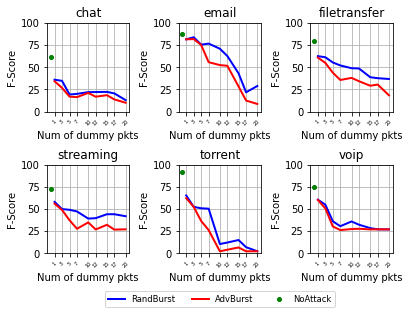

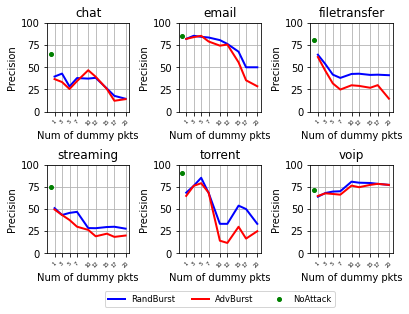

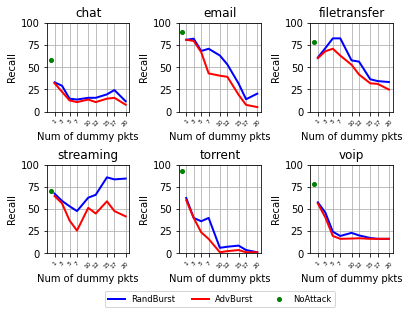

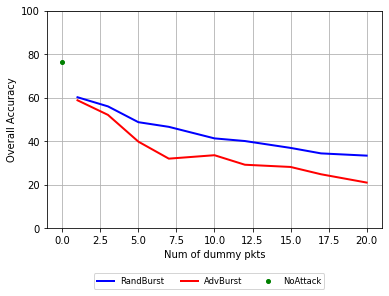

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import math


result_index = 0
f_score_name = "F-Score"
precision_name = "Precision"
recal_name = "Recall"
advburst_oh_name = "AdvBurstOverHead"
class_name = data.name[index_name]
for attack in AttackList:
    for i in range(len(class_name)):
        attack[f_score_name + class_name[i]] = result_stat[result_index, 0][i]
        attack[precision_name + class_name[i]] = result_stat[result_index, 1][i]
        attack[recal_name + class_name[i]] = result_stat[result_index, 2][i]
    attack['Accuracy'] = result_stat[result_index, 3]
    attack[advburst_oh_name + class_name[i]] = result_stat[result_index, 4]
    result_index += 1
#class_name = ['chat','email','filetransfer','streaming','torrent','voip']

RawAttackList = AttackList

def get_attack(attack_list,attack):
    for ref_attack,i in zip(attack_list,range(len(attack_list))):
        if ref_attack['RandAttack'] == attack['RandAttack'] and ref_attack['AdvBurstAttack'] == attack['AdvBurstAttack'] and ref_attack['AdvBurstOverHead'] == attack['AdvBurstOverHead']:
            return i
    return None


AttackList = []
for new_attack in RawAttackList:
    old_attack_index = get_attack(AttackList,new_attack)
    if old_attack_index == None:
        new_attack['num_of_exper'] = 1
        AttackList.append(new_attack)
    else:
        for clsname in class_name:
            AttackList[old_attack_index][f_score_name+clsname] += new_attack[f_score_name+clsname]
            AttackList[old_attack_index][precision_name+clsname] += new_attack[precision_name+clsname]
            AttackList[old_attack_index][recal_name+clsname] += new_attack[recal_name+clsname]
        AttackList[old_attack_index]['num_of_exper'] += 1
for attack in AttackList:
    for clsname in class_name:
        attack[f_score_name+clsname] = attack[f_score_name+clsname] / attack['num_of_exper']
        attack[precision_name+clsname] = attack[precision_name+clsname] / attack['num_of_exper']
        attack[recal_name+clsname] = attack[recal_name+clsname] / attack['num_of_exper']
print("done")

flag_recall = 0
class Attack_Result:
    def __init__(self,atc_res_list,metric_name,cls_name):
        self.attack_res = {}
        natural = []
        port = []
        rand = []
        AdvBurst = []
        rand_port = []
        AdvBurst_port = []
        AdvBurstOverHead = []
        for attack in atc_res_list:
            assert (attack["AdvBurstAttack"] != attack["RandAttack"]), "Attack information is wrong"
            if math.isnan(attack[metric_name + cls_name]) :
                attack[metric_name + cls_name] = 0
            if attack["AdvBurstAttack"] == 1 and attack["Steps"] == 0:
                natural.append(attack[metric_name+cls_name])
            if attack["AdvBurstAttack"] == 1 and attack["Steps"] > 0:
                AdvBurst.append(attack[metric_name+cls_name])
                AdvBurstOverHead.append(attack["AdvBurstOverHead"])
            if attack["RandAttack"] == 1:
                rand.append(attack[metric_name+cls_name])
        self.attack_res["natural"] = np.array(natural)
        self.attack_res["port"] = np.array(port)
        self.attack_res["rand"] = np.array(rand)
        self.attack_res["rand_port"] = np.array(rand_port)
        self.attack_res["AdvBurst"] = np.array(AdvBurst)
        self.attack_res["AdvBurst_port"] = np.array(AdvBurst_port)
        self.attack_res["AdvBurstOverHead"] = np.array(AdvBurstOverHead)


class metrics:
        def __init__(self,atc_res_list,cls_name=None):
            if cls_name:
                self.f_score = Attack_Result(atc_res_list,f_score_name,cls_name)
                self.precision = Attack_Result(atc_res_list,precision_name,cls_name)
                self.recall = Attack_Result(atc_res_list,recal_name,cls_name)
            else:
                self.accuracy = Attack_Result(atc_res_list,'Accuracy',cls_name='')

class chart_data:
    def __init__(self,Attck_result_list):
        self.classes = {}
        self.classes["chat"] = metrics(atc_res_list=Attck_result_list,cls_name=class_name[0])
        self.classes["email"] = metrics(atc_res_list=Attck_result_list,cls_name=class_name[1])
        self.classes["filetransfer"] = metrics(atc_res_list=Attck_result_list,cls_name=class_name[2])
        self.classes["streaming"] = metrics(atc_res_list=Attck_result_list,cls_name=class_name[3])
        self.classes["torrent"] = metrics(atc_res_list=Attck_result_list,cls_name=class_name[4])
        self.classes["voip"] = metrics(atc_res_list=Attck_result_list,cls_name=class_name[5])

acc_data = metrics(AttackList)

cdata = chart_data(Attck_result_list=AttackList)

if flag_recall == 0:
    fig, axes = plt.subplots(2, 3)
    fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.6, hspace=0.6)

    class_index = 0
    for ax in axes.flatten():
        ax.set_title(class_name[class_index])
        if len(cdata.classes[class_name[class_index]].f_score.attack_res["rand"]) is not 0:
            ax.plot(cdata.classes[class_name[class_index]].f_score.attack_res["AdvBurstOverHead"], cdata.classes[class_name[class_index]].f_score.attack_res["rand"],
                   color='blue', linewidth=2, label="RandBurst")
        if len(cdata.classes[class_name[class_index]].f_score.attack_res["AdvBurst"]) is not 0:
            ax.plot(cdata.classes[class_name[class_index]].f_score.attack_res["AdvBurstOverHead"], cdata.classes[class_name[class_index]].f_score.attack_res["AdvBurst"],
                  color='red', linewidth=2, label="AdvBurst")
        if len(cdata.classes[class_name[class_index]].f_score.attack_res["AdvBurst_port"]) is not 0:
            ax.plot(cdata.classes[class_name[class_index]].f_score.attack_res["AdvBurstOverHead"],cdata.classes[class_name[class_index]].f_score.attack_res["AdvBurst_port"],
                color='red', linewidth=2, linestyle='dashed', label="AdvBurst+Port")
        if cdata.classes[class_name[class_index]].f_score.attack_res["natural"]:
            ax.plot([0], cdata.classes[class_name[class_index]].f_score.attack_res["natural"], marker='o', markerfacecolor='green', markersize=4,
                 color='green', linewidth=0, label="NoAttack")
        if cdata.classes[class_name[class_index]].f_score.attack_res["port"]:
            ax.plot([0], cdata.classes[class_name[class_index]].f_score.attack_res["port"], marker='o', markerfacecolor='violet', markersize=4,
                 color='violet', linewidth=0, label="Port")
        ax.set( ylim=(0, 100))
        ax.grid()
        ax.set_xticks(cdata.classes[class_name[class_index]].precision.attack_res["AdvBurstOverHead"])
        ax.tick_params(axis='x', rotation=45, labelsize=5)
        if class_index == 4:
            handles, labels = ax.get_legend_handles_labels()

        class_index += 1

    for ax in axes.flat:
        ax.set(xlabel='Num of dummy pkts', ylabel='F-Score')
    fig.legend( handles, labels ,loc = 'lower center', bbox_to_anchor = (0,-0.1,1,1),
                bbox_transform = plt.gcf().transFigure, ncol=6,fontsize='small' )
    fig.show()


if flag_recall == 0:
    fig, axes = plt.subplots(2,3)
    fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.6, hspace=0.6)

    class_index = 0
    for ax in axes.flatten():
        ax.set_title(class_name[class_index])
        if len(cdata.classes[class_name[class_index]].precision.attack_res["rand"]) is not 0:
            ax.plot(cdata.classes[class_name[class_index]].precision.attack_res["AdvBurstOverHead"], cdata.classes[class_name[class_index]].precision.attack_res["rand"],
                   color='blue', linewidth=2, label="RandBurst")
        if len(cdata.classes[class_name[class_index]].precision.attack_res["AdvBurst"]) is not 0:
            ax.plot(cdata.classes[class_name[class_index]].precision.attack_res["AdvBurstOverHead"], cdata.classes[class_name[class_index]].precision.attack_res["AdvBurst"],
                  color='red', linewidth=2, label="AdvBurst")
        if len(cdata.classes[class_name[class_index]].precision.attack_res["AdvBurst_port"]) is not 0:
            ax.plot(cdata.classes[class_name[class_index]].precision.attack_res["AdvBurstOverHead"],cdata.classes[class_name[class_index]].precision.attack_res["AdvBurst_port"],
                color='red', linewidth=2, linestyle='dashed', label="AdvBurst+Port")
        if cdata.classes[class_name[class_index]].precision.attack_res["natural"]:
            ax.plot([0], cdata.classes[class_name[class_index]].precision.attack_res["natural"], marker='o', markerfacecolor='green', markersize=4,
                 color='green', linewidth=0, label="NoAttack")
        if cdata.classes[class_name[class_index]].precision.attack_res["port"]:
            ax.plot([0], cdata.classes[class_name[class_index]].precision.attack_res["port"], marker='o', markerfacecolor='violet', markersize=4,
                 color='violet', linewidth=0, label="Port")
        ax.set( ylim=(0, 100))
        ax.grid()
        ax.set_xticks(cdata.classes[class_name[class_index]].precision.attack_res["AdvBurstOverHead"])
        ax.tick_params(axis='x', rotation=45, labelsize=5)
        if class_index == 4:
            handles, labels = ax.get_legend_handles_labels()

        class_index += 1
    for ax in axes.flat:
        ax.set(xlabel='Num of dummy pkts', ylabel='Precision')
    fig.legend( handles, labels, loc = 'lower center', bbox_to_anchor = (0,-0.1,1,1),
                bbox_transform = plt.gcf().transFigure, ncol=6,fontsize='small' )
    fig.show()


if True:
    fig, axes = plt.subplots(2,3)
    fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.6, hspace=0.6)

    class_index = 0
    for ax in axes.flatten():
        ax.set_title(class_name[class_index])
        if len(cdata.classes[class_name[class_index]].recall.attack_res["rand"])is not 0 :
            ax.plot(cdata.classes[class_name[class_index]].recall.attack_res["AdvBurstOverHead"], cdata.classes[class_name[class_index]].recall.attack_res["rand"],
                   color='blue', linewidth=2, label="RandBurst")
        if len(cdata.classes[class_name[class_index]].recall.attack_res["AdvBurst"]) is not 0 :
            ax.plot(cdata.classes[class_name[class_index]].recall.attack_res["AdvBurstOverHead"], cdata.classes[class_name[class_index]].recall.attack_res["AdvBurst"],
                  color='red', linewidth=2, label="AdvBurst")
        if len(cdata.classes[class_name[class_index]].recall.attack_res["AdvBurst_port"]) is not 0:
            ax.plot(cdata.classes[class_name[class_index]].recall.attack_res["AdvBurstOverHead"], cdata.classes[class_name[class_index]].recall.attack_res["AdvBurst_port"],
                color='red', linewidth=2, linestyle='dashed', label="AdvBurst+Port")
        if cdata.classes[class_name[class_index]].recall.attack_res["natural"]:
            ax.plot([0], cdata.classes[class_name[class_index]].recall.attack_res["natural"], marker='o', markerfacecolor='green', markersize=4,
                 color='green', linewidth=0, label="NoAttack")
        if cdata.classes[class_name[class_index]].recall.attack_res["port"]:
            ax.plot([0], cdata.classes[class_name[class_index]].recall.attack_res["port"], marker='o', markerfacecolor='violet', markersize=4,
                 color='violet', linewidth=0, label="Port")
        ax.set( ylim=(0, 100))
        ax.grid()
        ax.set_xticks(cdata.classes[class_name[class_index]].precision.attack_res["AdvBurstOverHead"])
        ax.tick_params(axis='x', rotation=45, labelsize=6)
        if class_index == 4:
            handles, labels = ax.get_legend_handles_labels()

        class_index += 1



    for ax in axes.flat:
        ax.set(xlabel='Num of dummy pkts', ylabel='Recall')
    fig.legend( handles, labels, loc = 'lower center', bbox_to_anchor = (0,-0.1,1,1),
                bbox_transform = plt.gcf().transFigure, ncol=6,fontsize='small' )
    fig.show()

if True:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    if len(acc_data.accuracy.attack_res['rand']) is not 0:
        ax.plot(acc_data.accuracy.attack_res['AdvBurstOverHead'],acc_data.accuracy.attack_res['rand'],color='blue', linewidth=2, label="RandBurst")
    if len(acc_data.accuracy.attack_res['AdvBurst']) is not 0:
        ax.plot(acc_data.accuracy.attack_res['AdvBurstOverHead'],acc_data.accuracy.attack_res['AdvBurst'],color='red', linewidth=2, label="AdvBurst")
    if len(acc_data.accuracy.attack_res['natural']) is not 0:
        ax.plot([0.0],acc_data.accuracy.attack_res['natural'], marker='o', markerfacecolor='green', markersize=4,
                 color='green', linewidth=0, label="NoAttack")
    if len(acc_data.accuracy.attack_res['port']) is not 0:
        ax.plot([0.0],acc_data.accuracy.attack_res['port'],marker='o', markerfacecolor='violet', markersize=4,
                 color='violet', linewidth=0, label="Port")
    fig.legend( handles, labels, loc = 'lower center', bbox_to_anchor = (0,-0.1,1,1),
                bbox_transform = plt.gcf().transFigure, ncol=6,fontsize='small' )
    ax.set(xlabel='Num of dummy pkts', ylabel='Overall Accuracy')
    ax.set( ylim=(0, 100))
    ax.grid()
    plt.show()
